## Filter data around semidiurnal frequency and store subsample (time) in diags directory

In [ ]:
import numpy as np
import geopandas as gpd

import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline

from xhistogram.xarray import histogram
import dask.dataframe as dd
#import cartopy.crs as ccrs
#import cartopy.feature as cfeature

import mitequinox.utils as ut
from mitequinox.plot import *
import mitequinox.parcels as pa
from xmitgcm import llcreader

from scipy import signal
import scipy.ndimage as im

from sympy import Symbol, pi, atan, factor, lambdify

import mitequinox.plot as pl
import mitequinox.sigp as sp

from fsspec.implementations.local import LocalFileSystem

In [2]:
from dask.distributed import Client, LocalCluster
#
#cluster = LocalCluster()
#
from dask_jobqueue import PBSCluster
cluster = PBSCluster() #processes=7, cores=7
w = cluster.scale(jobs=15
                 )
#
client = Client(cluster)

In [3]:
isel = dict(face=10)
#sel = dict(i=slice(2700,2900), j=slice(2900,3100))
sel = dict(i=slice(0,None), j=slice(3801,None))
#, i_g=slice(3000,3100), j_g=slice(3000,3100)) # North East Hawaii
#sel = dict(i=[3000,3010], j=[3000,3010], i_g=[3000,3010], j_g=[3000,3010]) # North East Hawaii

In [4]:
def convolve(x, h=None, hilbert=False):
    """ Convolve an input signal with a kernel
    Optionaly compute the Hilbert transform of the resulting time series
    """
    #x_f = im.convolve1d(x, h, axis=1, mode='constant')
    x_f = signal.filtfilt(h, [1], x, axis=-1,padlen=0)#
    if hilbert:
        return signal.hilbert(x_f)
    else:
        return x_f

def filt(v, h, hilbert=False):
    output_dtype = complex if hilbert else float
    gufunc_kwargs = dict(output_sizes={'time': len(v.time)})
    return xr.apply_ufunc(convolve, v, kwargs={'h': h, 'hilbert': hilbert},
                    dask='parallelized', output_dtypes=[output_dtype],
                    input_core_dims=[['time']],
                    output_core_dims=[['time']],
                    dask_gufunc_kwargs = gufunc_kwargs,
                         )

In [7]:
ds = xr.merge([xr.open_zarr(ut.work_data_dir+'rechunked/SSU.zarr')
               ,xr.open_zarr(ut.work_data_dir+'rechunked/SSV.zarr')
              ])
#xr.open_zarr(ut.work_data_dir+'rechunked/Eta.zarr')
grd = ut.load_grd()[['XC', 'YC', 'Depth']].persist()

In [8]:
print(ds.isel(**isel).i,ds.isel(**isel).j)

<xarray.DataArray 'i' (i: 2160)>
array([   0,    2,    4, ..., 4314, 4316, 4318])
Coordinates:
    face     int64 10
  * i        (i) int64 0 2 4 6 8 10 12 14 ... 4306 4308 4310 4312 4314 4316 4318 <xarray.DataArray 'j' (j: 2160)>
array([   0,    2,    4, ..., 4314, 4316, 4318])
Coordinates:
    face     int64 10
  * j        (j) int64 0 2 4 6 8 10 12 14 ... 4306 4308 4310 4312 4314 4316 4318


In [8]:
ds['lon'] = 0*ds.face+grd.XC
ds['lat'] = 0*ds.face+grd.YC
ds = ds.drop(['i_g','j_g']).rename({'i_g':'i','j_g':'j'})
#ds = ds.drop(['i_g']).rename({'i_g':'i'})#.drop(['i_g','j_g'])
#dsi = ds#.isel(time=slice(0*24,100*24))

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/xarray/core/indexing.py:1375: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/xarray/core/indexing.py:1375: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    

In [9]:
isel=dict(face=9)
V = ['SSU','SSV']#'zonal_velocity','meridional_velocity'
path = '/home1/datawork/zcaspar/mit4320/filtered_E/'
Sel = [dict(i=slice(0,None), j=slice(0,1200)),dict(i=slice(0,None), j=slice(1201,2400)),
       dict(i=slice(0,None), j=slice(2401,3600)),dict(i=slice(0,None), j=slice(3601,None))]
#dsp = ds.isel(**isel).persist()

In [10]:
#for i,sel in zip(range(len(Sel)),Sel):
sel=Sel[3]
dsp = ds.isel(**isel).sel(**sel).persist()
dsp = dsp.chunk({"time": -1})#.persist()
#dsp = dsp.chunk({"time": -1,'i':20,'j':30})#.persist()
dsp = dsp.assign_coords({'lon':dsp.lon,'lat':dsp.lat}).persist()

In [11]:
ds_hat,h = wrap_filter(dsp,omega,Tw,dband,V)

In [12]:
_ds = ds_hat.isel(time=slice(0,None,6))
_ds.attrs.update({'bandwidth':dband*2,'Tw':Tw,'omega':omega,'dt':'6h'})
_ds = _ds.persist()
_ds = _ds.chunk({'time':-1,'i':96,'j':144})

In [15]:
ut.store_diagnostic('ZC_filtered_itide_face9_3', _ds,directory=path)
#client.restart()

#dsp = dsp.chunk({"time": -1}).persist() #,"i":10,"j":10

data stored in /home1/datawork/zcaspar/mit4320/filtered_E/ZC_filtered_itide_face9_3.zarr


In [16]:
client.restart()
#cluster.close()

distributed.scheduler - ERROR - Not all workers responded positively: ['timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed

Client Scheduler: tcp://10.148.0.218:56255 Dashboard: http://10.148.0.218:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [7]:
dsp = ds.isel(**isel).sel(**sel)

#dsp = dsp.chunk({"time": -1}).persist() #,"i":10,"j":10

dsp = dsp.chunk({"time": -1,'i':20,'j':30}).persist()
dsp

<xarray.Dataset>
Dimensions:  (i: 2160, j: 259, time: 8784)
Coordinates:
  * i        (i) int64 0 2 4 6 8 10 12 14 ... 4306 4308 4310 4312 4314 4316 4318
  * j        (j) int64 3802 3804 3806 3808 3810 ... 4310 4312 4314 4316 4318
    face     int64 10
  * time     (time) datetime64[ns] 2011-11-15 ... 2012-11-14T23:00:00
    XC       (j, i) float32 dask.array<chunksize=(30, 20), meta=np.ndarray>
    YC       (j, i) float32 dask.array<chunksize=(30, 20), meta=np.ndarray>
    Depth    (j, i) float32 dask.array<chunksize=(30, 20), meta=np.ndarray>
    CS       (j, i) float32 dask.array<chunksize=(30, 20), meta=np.ndarray>
    SN       (j, i) float32 dask.array<chunksize=(30, 20), meta=np.ndarray>
    rA       (j, i) float32 dask.array<chunksize=(30, 20), meta=np.ndarray>
Data variables:
    SSU      (time, j, i) float32 dask.array<chunksize=(8784, 30, 20), meta=np.ndarray>
    SSV      (time, j, i) float32 dask.array<chunksize=(8784, 30, 20), meta=np.ndarray>
    lon      (j, i) float64 dask.array<chunksize=(30, 20), meta=np.ndarray>
    lat      (j, i) float64 dask.array<chunksize=(30, 20), meta=np.ndarray>

In [8]:
#dsp['zonal_velocity'] = dsp['SSU']*dsp.CS - dsp['SSV']*dsp.SN
#dsp['meridional_velocity'] =  dsp['SSU']*dsp.SN + dsp['SSV']*dsp.CS
dsp = dsp.assign_coords({'lon':dsp.lon,'lat':dsp.lat}).persist()

#dsp = dsp.drop(['SSU','SSV']).persist()


In [9]:
dsp = dsp.drop(['SSU','SSV']).persist()
dsp.XC.shape

dsp#.SSU.chunk

<xarray.Dataset>
Dimensions:              (i: 2160, j: 651, time: 8784)
Coordinates:
  * i                    (i) int64 0 2 4 6 8 10 ... 4310 4312 4314 4316 4318
  * j                    (j) int64 0 2 4 6 8 10 ... 1292 1294 1296 1298 1300
    face                 int64 10
  * time                 (time) datetime64[ns] 2011-11-15 ... 2012-11-14T23:0...
    XC                   (j, i) float32 dask.array<chunksize=(30, 20), meta=np.ndarray>
    YC                   (j, i) float32 dask.array<chunksize=(30, 20), meta=np.ndarray>
    Depth                (j, i) float32 dask.array<chunksize=(30, 20), meta=np.ndarray>
    CS                   (j, i) float32 dask.array<chunksize=(30, 20), meta=np.ndarray>
    SN                   (j, i) float32 dask.array<chunksize=(30, 20), meta=np.ndarray>
    rA                   (j, i) float32 dask.array<chunksize=(30, 20), meta=np.ndarray>
    lon                  (j, i) float64 dask.array<chunksize=(30, 20), meta=np.ndarray>
    lat                  (j, i) float64 dask.array<chunksize=(30, 20), meta=np.ndarray>
Data variables:
    zonal_velocity       (time, j, i) float32 dask.array<chunksize=(8784, 30, 20), meta=np.ndarray>
    meridional_velocity  (time, j, i) float32 dask.array<chunksize=(8784, 30, 20), meta=np.ndarray>

In [10]:
path = '/home1/datawork/zcaspar/mit4320/filtered_E/'
ut.store_diagnostic('rechunked_face7_0', dsp,directory=path)

data stored in /home1/datawork/zcaspar/mit4320/filtered_E/rechunked_face7_0.zarr


In [51]:
client.restart()

distributed.scheduler - ERROR - Not all workers responded positively: ['timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed

Client Scheduler: tcp://10.148.0.242:58278 Dashboard: http://10.148.0.242:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


### Definition of filter : filter length and bandwidth

In [12]:
path = '/home1/datawork/zcaspar/mit4320/filtered_E/'
dsp = xr.open_zarr(path+'rechunked_face7_0.zarr').persist()

In [13]:
dsp.chunk

<bound method Dataset.chunk of <xarray.Dataset>
Dimensions:  (i: 2160, j: 659, time: 8784)
Coordinates:
    CS       (j, i) float32 dask.array<chunksize=(659, 2160), meta=np.ndarray>
    Depth    (j, i) float32 dask.array<chunksize=(659, 2160), meta=np.ndarray>
    SN       (j, i) float32 dask.array<chunksize=(659, 2160), meta=np.ndarray>
    XC       (j, i) float32 dask.array<chunksize=(659, 2160), meta=np.ndarray>
    YC       (j, i) float32 dask.array<chunksize=(659, 2160), meta=np.ndarray>
  * i        (i) int64 0 2 4 6 8 10 12 14 ... 4306 4308 4310 4312 4314 4316 4318
  * j        (j) int64 3002 3004 3006 3008 3010 ... 4310 4312 4314 4316 4318
    lat      (j, i) float64 dask.array<chunksize=(659, 2160), meta=np.ndarray>
    lon      (j, i) float64 dask.array<chunksize=(659, 2160), meta=np.ndarray>
    rA       (j, i) float32 dask.array<chunksize=(659, 2160), meta=np.ndarray>
  * time     (time) datetime64[ns] 2011-11-15 ... 2012-11-14T23:00:00
Data variables:
    SSU      (time, 

In [5]:
dt = 1/24 # in days

tidal_omega = sp.get_tidal_frequencies("M2", "K2","S2","N2")
omega_M2,omega_S2,omega_N2,omega_K2, domega, name = tidal_omega["M2"],tidal_omega["S2"],tidal_omega["N2"],tidal_omega["K2"], .2, "semidiurnal"
omega = (omega_M2+omega_S2)/2#(omega_M2+omega_S2)/2
Tw = 30
dband = 0.2

In [6]:
def wrap_filter(_ds,om,Tw,dband,V,dt=dt):
    h = sp.generate_filter(omega, T=Tw, dt=dt, bandwidth=dband, normalized_bandwidth=None)
    time = np.arange(0,_ds['time'].values.size*dt,dt)
    exp = np.exp(-1j*omega*2*np.pi*time)
    ds_hat={}
    for v in V:
        ds_hat[v+'_hat'] = filt(_ds[v], h,hilbert=True).persist()
        ds_hat[v+'_hat'] = ds_hat[v+'_hat'].assign_coords({'lon':ds_hat[v+'_hat'].lon,'lat':ds_hat[v+'_hat'].lat})
        ds_hat[v+'_demodulated'] = ds_hat[v+'_hat']*exp
        #ds_hat[v+'_demodulated_real']=ds_hat[v+'_demodulated'].real
        #ds_hat[v+'_demodulated_imag']=ds_hat[v+'_demodulated'].imag
    ds_hat = xr.merge([ds_hat[v].rename(v) for v in ds_hat.keys()])
    return ds_hat,h

In [11]:
V = ['SSU','SSV']#'zonal_velocity','meridional_velocity'

ds_hat,h = wrap_filter(dsp,omega,Tw,dband,V)

In [ ]:
cluster.close()

In [12]:
h_hat, w = sp.filter_response(h, dt=dt)

No handles with labels found to put in legend.


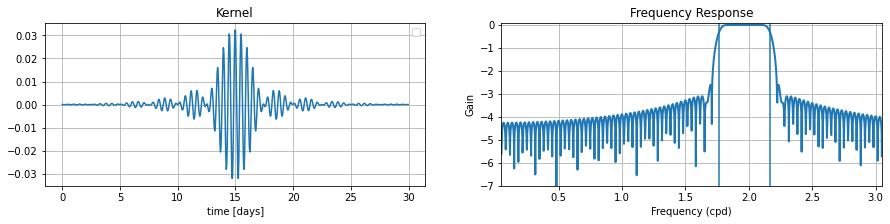

In [13]:
fig, axes = plt.subplots(1,2, figsize=(15,3))
ax = axes[0]
    #t = np.arange(0, h.size)*dt
t = np.arange(0, h.size)*dt
ax.plot(t, h);
ax.grid();
ax.set_xlabel('time [days]')
ax.set_title('Kernel')
ax.legend()
ax = axes[1]
ax.plot(w, np.log10(abs(h_hat)), linewidth=2)
ax.axvline(omega-dband)#, color='k')
ax.axvline(omega+dband)#, color='k')
ax.set_xlabel('Frequency (cpd)')
ax.set_ylabel('Gain')
ax.set_title('Frequency Response')
ax.set_ylim(-0.05, 1.05)
ax.set_ylim(-7, 0.1)
ax.set_xlim(0.05, 3.05)
ax.grid(True)
    #H.plot.line(hue='T_window')

### Plot

In [ ]:

dsp['zonal_velocity'] = dsp['SSU']*dsp.CS - dsp['SSV']*dsp.SN
dsp['meridional_velocity'] =  dsp['SSU']*dsp.SN + dsp['SSV']*dsp.CS

In [29]:
test_u = (ds_hat.zonal_velocity_hat-(ds_hat['SSU_hat']*ds_hat.CS - ds_hat['SSV_hat']*ds_hat.SN)).compute()
test_v = (ds_hat.meridional_velocity_hat-(ds_hat['SSU_hat']*ds_hat.SN + ds_hat['SSV_hat']*ds_hat.CS)).compute()

In [30]:
test_demod_u = (ds_hat.zonal_velocity_demodulated-(ds_hat['SSU_demodulated']*ds_hat.CS - ds_hat['SSV_demodulated']*ds_hat.SN)).compute()
test_demod_v = (ds_hat.meridional_velocity_demodulated-(ds_hat['SSU_demodulated']*ds_hat.SN + ds_hat['SSV_demodulated']*ds_hat.CS)).compute()

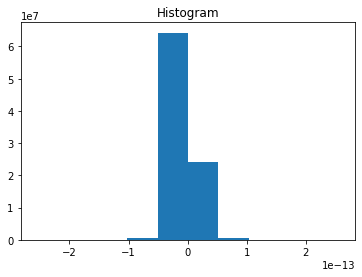

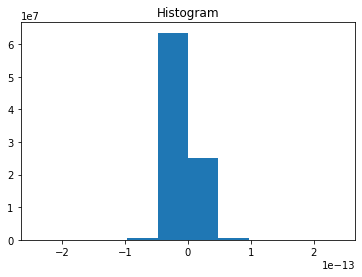

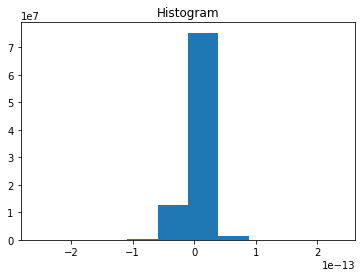

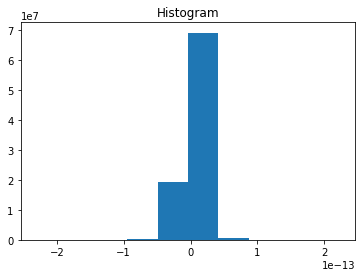

In [32]:
for t in [test_u,test_v,test_demod_u,test_demod_v]:
    plt.figure()
    t.plot()


/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in cdouble_scalars
  ret = ret.dtype.type(ret / rcount)
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in cdouble_scalars
  ret = ret.dtype.type(ret / rcount)


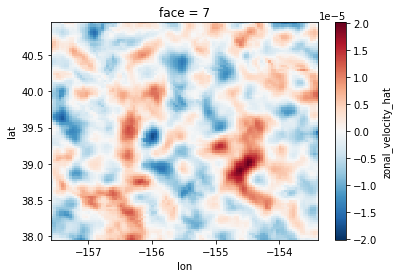

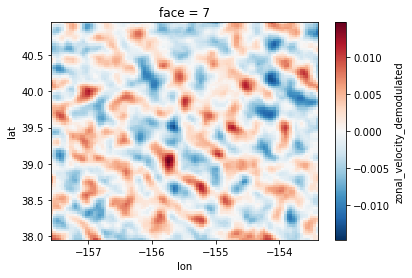

In [14]:
fig,ax = plt.subplots()
ds_hat.zonal_velocity_hat.mean('time').real.plot(ax=ax,x='lon',y='lat')
fig,ax = plt.subplots()
ds_hat.zonal_velocity_demodulated.mean('time').real.plot(ax=ax,x='lon',y='lat')

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in cdouble_scalars
  ret = ret.dtype.type(ret / rcount)
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in cdouble_scalars
  ret = ret.dtype.type(ret / rcount)


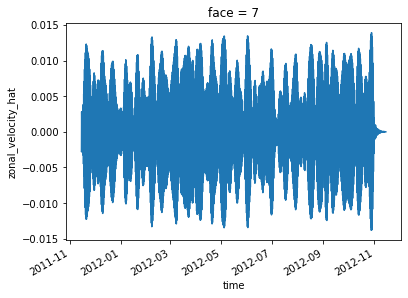

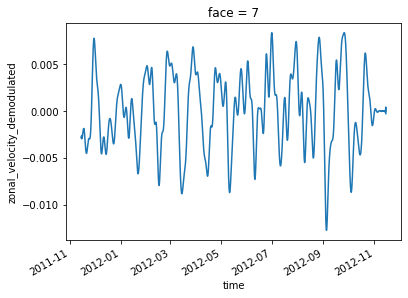

In [15]:
fig,ax = plt.subplots()
ds_hat.zonal_velocity_hat.mean(['i','j']).real.plot(ax=ax)
fig,ax = plt.subplots()
ds_hat.zonal_velocity_demodulated.mean(['i','j']).real.plot(ax=ax)

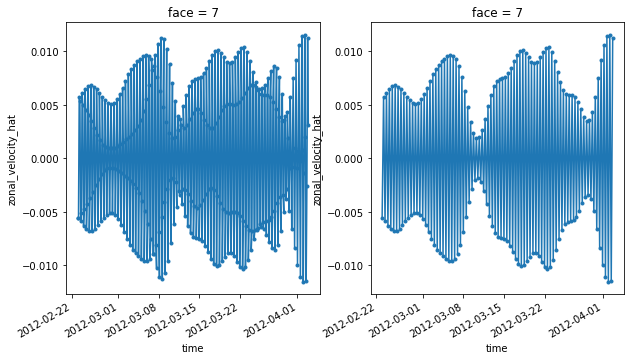

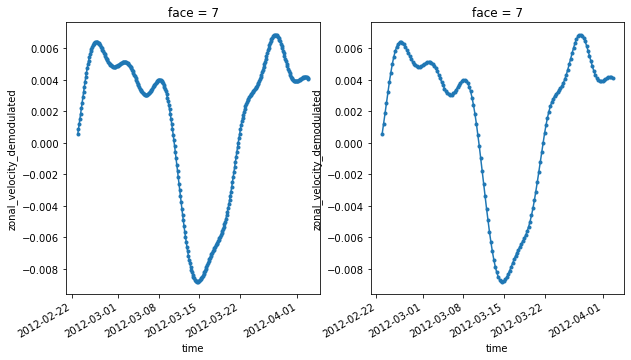

In [21]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
ds_hat.zonal_velocity_hat.isel(time=slice(100*24,140*24)).isel(time=slice(0,None,3)).mean(['i','j']).real.plot(ax=ax[0],marker='.')
ds_hat.zonal_velocity_hat.isel(time=slice(100*24,140*24)).isel(time=slice(0,None,6)).mean(['i','j']).real.plot(ax=ax[1],marker='.')
fig,ax = plt.subplots(1,2,figsize=(10,5))
ds_hat.zonal_velocity_demodulated.isel(time=slice(100*24,140*24)).isel(time=slice(0,None,3)).mean(['i','j']).real.plot(ax=ax[0],marker='.')
ds_hat.zonal_velocity_demodulated.isel(time=slice(100*24,140*24)).isel(time=slice(0,None,6)).mean(['i','j']).real.plot(ax=ax[1],marker='.')

In [22]:
ds_hat

<xarray.Dataset>
Dimensions:                          (i: 2160, j: 101, time: 8784)
Coordinates:
  * i                                (i) int64 0 2 4 6 8 ... 4312 4314 4316 4318
  * j                                (j) int64 2900 2902 2904 ... 3096 3098 3100
    face                             int64 7
  * time                             (time) datetime64[ns] 2011-11-15 ... 201...
    XC                               (j, i) float32 dask.array<chunksize=(101, 2160), meta=np.ndarray>
    YC                               (j, i) float32 dask.array<chunksize=(101, 2160), meta=np.ndarray>
    Depth                            (j, i) float32 dask.array<chunksize=(101, 2160), meta=np.ndarray>
    CS                               (j, i) float32 dask.array<chunksize=(101, 2160), meta=np.ndarray>
    SN                               (j, i) float32 dask.array<chunksize=(101, 2160), meta=np.ndarray>
    rA                               (j, i) float32 dask.array<chunksize=(101, 2160), meta=np.ndarray>
    lon                              (j, i) float64 dask.array<chunksize=(101, 2160), meta=np.ndarray>
    lat                              (j, i) float64 dask.array<chunksize=(101, 2160), meta=np.ndarray>
Data variables:
    zonal_velocity_hat               (j, i, time) complex128 dask.array<chunksize=(86, 144, 8784), meta=np.ndarray>
    zonal_velocity_demodulated       (j, i, time) complex128 dask.array<chunksize=(86, 144, 8784), meta=np.ndarray>
    meridional_velocity_hat          (j, i, time) complex128 dask.array<chunksize=(86, 144, 8784), meta=np.ndarray>
    meridional_velocity_demodulated  (j, i, time) complex128 dask.array<chunksize=(86, 144, 8784), meta=np.ndarray>

In [12]:
_ds = ds_hat.isel(time=slice(0,None,6))

_ds.attrs.update({'bandwidth':dband*2,'Tw':Tw,'omega':omega,'dt':'6h'})

_ds

<xarray.Dataset>
Dimensions:          (i: 2160, j: 259, time: 1464)
Coordinates:
  * i                (i) int64 0 2 4 6 8 10 12 ... 4308 4310 4312 4314 4316 4318
  * j                (j) int64 3802 3804 3806 3808 3810 ... 4312 4314 4316 4318
    face             int64 10
  * time             (time) datetime64[ns] 2011-11-15 ... 2012-11-14T18:00:00
    XC               (j, i) float32 dask.array<chunksize=(30, 20), meta=np.ndarray>
    YC               (j, i) float32 dask.array<chunksize=(30, 20), meta=np.ndarray>
    Depth            (j, i) float32 dask.array<chunksize=(30, 20), meta=np.ndarray>
    CS               (j, i) float32 dask.array<chunksize=(30, 20), meta=np.ndarray>
    SN               (j, i) float32 dask.array<chunksize=(30, 20), meta=np.ndarray>
    rA               (j, i) float32 dask.array<chunksize=(30, 20), meta=np.ndarray>
    lon              (j, i) float64 dask.array<chunksize=(30, 20), meta=np.ndarray>
    lat              (j, i) float64 dask.array<chunksize=(30, 20), meta=np.ndarray>
Data variables:
    SSU_hat          (j, i, time) complex128 dask.array<chunksize=(30, 20, 1464), meta=np.ndarray>
    SSU_demodulated  (j, i, time) complex128 dask.array<chunksize=(30, 20, 1464), meta=np.ndarray>
    SSV_hat          (j, i, time) complex128 dask.array<chunksize=(30, 20, 1464), meta=np.ndarray>
    SSV_demodulated  (j, i, time) complex128 dask.array<chunksize=(30, 20, 1464), meta=np.ndarray>
Attributes:
    bandwidth:  0.4
    Tw:         30
    omega:      1.9661368071336223
    dt:         6h

In [13]:
_ds = _ds.persist()

In [14]:
_ds.chunk

<bound method Dataset.chunk of <xarray.Dataset>
Dimensions:          (i: 2160, j: 259, time: 1464)
Coordinates:
  * i                (i) int64 0 2 4 6 8 10 12 ... 4308 4310 4312 4314 4316 4318
  * j                (j) int64 3802 3804 3806 3808 3810 ... 4312 4314 4316 4318
    face             int64 10
  * time             (time) datetime64[ns] 2011-11-15 ... 2012-11-14T18:00:00
    XC               (j, i) float32 dask.array<chunksize=(30, 20), meta=np.ndarray>
    YC               (j, i) float32 dask.array<chunksize=(30, 20), meta=np.ndarray>
    Depth            (j, i) float32 dask.array<chunksize=(30, 20), meta=np.ndarray>
    CS               (j, i) float32 dask.array<chunksize=(30, 20), meta=np.ndarray>
    SN               (j, i) float32 dask.array<chunksize=(30, 20), meta=np.ndarray>
    rA               (j, i) float32 dask.array<chunksize=(30, 20), meta=np.ndarray>
    lon              (j, i) float64 dask.array<chunksize=(30, 20), meta=np.ndarray>
    lat              (j, i) flo

In [15]:
_ds = _ds.chunk({'time':-1,'i':96,'j':144
                })

In [16]:
#path = '/home/datawork-lops-osi/equinox/mit4320/filtered_itide/'
path = '/home1/datawork/zcaspar/mit4320/filtered_E/'
ut.store_diagnostic('ZC_filtered_itide_face10_3', _ds,directory=path)

data stored in /home1/datawork/zcaspar/mit4320/filtered_E/ZC_filtered_itide_face10_3.zarr


In [21]:
cluster.close()
#client.restart()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError


In [17]:
path = '/home1/datawork/zcaspar/mit4320/filtered_E/'
#ds = xr.merge([xr.open_zarr(path+'ZC_filtered_itide_face7_'+str(i)+'.zarr') for i in [0,1,2]])
ds_0 = xr.open_zarr(path+'ZC_filtered_itide_face9_0.zarr').persist()
ds_1 = xr.open_zarr(path+'ZC_filtered_itide_face9_1.zarr').persist()
ds_2 = xr.open_zarr(path+'ZC_filtered_itide_face9_2.zarr').persist()
ds_3 = xr.open_zarr(path+'ZC_filtered_itide_face9_3.zarr').persist()

In [18]:
ds = xr.concat([ds_0,ds_1,ds_2,ds_3],dim='j').persist()#,ds_2,ds_3

In [38]:
ds

<xarray.Dataset>
Dimensions:          (i: 2160, j: 2160, time: 1464)
Coordinates:
    CS               (j, i) float32 dask.array<chunksize=(551, 2160), meta=np.ndarray>
    Depth            (j, i) float32 dask.array<chunksize=(551, 2160), meta=np.ndarray>
    SN               (j, i) float32 dask.array<chunksize=(551, 2160), meta=np.ndarray>
    XC               (j, i) float32 dask.array<chunksize=(551, 2160), meta=np.ndarray>
    YC               (j, i) float32 dask.array<chunksize=(551, 2160), meta=np.ndarray>
  * i                (i) int64 0 2 4 6 8 10 12 ... 4308 4310 4312 4314 4316 4318
  * j                (j) int64 0 2 4 6 8 10 12 ... 4308 4310 4312 4314 4316 4318
    lat              (j, i) float64 dask.array<chunksize=(551, 2160), meta=np.ndarray>
    lon              (j, i) float64 dask.array<chunksize=(551, 2160), meta=np.ndarray>
    rA               (j, i) float32 dask.array<chunksize=(551, 2160), meta=np.ndarray>
  * time             (time) datetime64[ns] 2011-11-15 ... 2012-11-14T18:00:00
Data variables:
    SSU_demodulated  (j, i, time) complex128 dask.array<chunksize=(144, 96, 1464), meta=np.ndarray>
    SSU_hat          (j, i, time) complex128 dask.array<chunksize=(144, 96, 1464), meta=np.ndarray>
    SSV_demodulated  (j, i, time) complex128 dask.array<chunksize=(144, 96, 1464), meta=np.ndarray>
    SSV_hat          (j, i, time) complex128 dask.array<chunksize=(144, 96, 1464), meta=np.ndarray>
Attributes:
    Tw:         30
    bandwidth:  0.4
    dt:         6h
    face:       0
    omega:      1.9661368071336223

In [42]:
ds = xr.combine_nested([[xr.open_zarr(path+'ZC_filtered_itide_face7_0.zarr'),
                         xr.open_zarr(path+'ZC_filtered_itide_face7_1.zarr')
                         ,xr.open_zarr(path+'ZC_filtered_itide_face7_2.zarr')
                         ,xr.open_zarr(path+'ZC_filtered_itide_face7_3.zarr')]],concat_dim=['i','j']).persist()
#ds = xr.combine_by_coords([[ds_0,ds_1.isel(i=slice(0,10),j=slice(0,10))]]).persist()

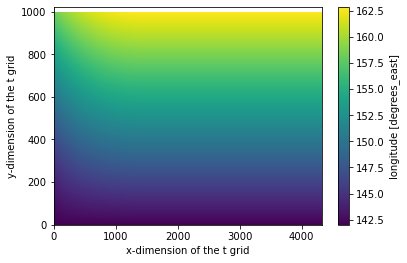

In [12]:
ds.XC.plot()

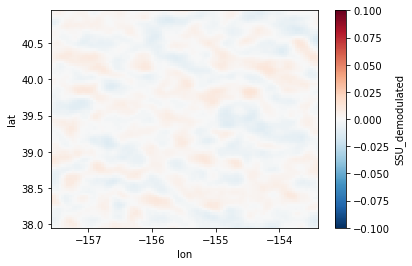

In [38]:
ds.SSU_demodulated.real.sel(i=slice(2700,2900),j=slice(2900,3100)).mean('time').plot(vmax=0.1,x='lon',y='lat')

In [9]:
ds

<xarray.Dataset>
Dimensions:          (i: 2160, j: 511, time: 1464)
Coordinates:
  * i                (i) int64 0 2 4 6 8 10 12 ... 4308 4310 4312 4314 4316 4318
    CS               (j, i) float32 dask.array<chunksize=(501, 2160), meta=np.ndarray>
    Depth            (j, i) float32 dask.array<chunksize=(501, 2160), meta=np.ndarray>
    SN               (j, i) float32 dask.array<chunksize=(501, 2160), meta=np.ndarray>
    XC               (j, i) float32 dask.array<chunksize=(501, 2160), meta=np.ndarray>
    YC               (j, i) float32 dask.array<chunksize=(501, 2160), meta=np.ndarray>
  * j                (j) int64 0 2 4 6 8 10 12 ... 1010 1012 1014 1016 1018 1020
    lat              (j, i) float64 dask.array<chunksize=(501, 2160), meta=np.ndarray>
    lon              (j, i) float64 dask.array<chunksize=(501, 2160), meta=np.ndarray>
    rA               (j, i) float32 dask.array<chunksize=(501, 2160), meta=np.ndarray>
  * time             (time) datetime64[ns] 2011-11-15 ... 2012-11-14T18:00:00
Data variables:
    SSU_demodulated  (j, i, time) complex128 dask.array<chunksize=(144, 96, 1464), meta=np.ndarray>
    SSU_hat          (j, i, time) complex128 dask.array<chunksize=(144, 96, 1464), meta=np.ndarray>
    SSV_demodulated  (j, i, time) complex128 dask.array<chunksize=(144, 96, 1464), meta=np.ndarray>
    SSV_hat          (j, i, time) complex128 dask.array<chunksize=(144, 96, 1464), meta=np.ndarray>

In [23]:
ds = xr.concat([ds,ds_2.isel(i=slice(1,None),j=slice(1,None))],dims='j').persist()

NameError: name 'ds_2' is not defined

In [100]:
ds = xr.combine_by_coords([xr.open_zarr(path+'ZC_filtered_itide_face7_0.zarr'),
                           xr.open_zarr(path+'ZC_filtered_itide_face7_1.zarr').isel(i=slice(1,None),j=slice(1,None))
                           ,xr.open_zarr(path+'ZC_filtered_itide_face7_2.zarr').isel(i=slice(1,None),j=slice(1,None))]).persist()

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  r

In [11]:
print(ds_0.i.values[0],ds_0.i.values[-1],ds_0.j.values[0],ds_0.j.values[-1])
print(ds_1.i.values[0],ds_1.i.values[-1],ds_1.j.values[0],ds_1.j.values[-1])
print(ds_2.i.values[0],ds_2.i.values[-1],ds_2.j.values[0],ds_2.j.values[-1])

0 1500 0 1500
1500 3000 1500 3000
3000 4318 3000 4318


In [83]:
print(ds_0.chunk,ds_2.chunk,ds_2.chunk)

<bound method Dataset.chunk of <xarray.Dataset>
Dimensions:          (i: 751, j: 751, time: 1464)
Coordinates:
    CS               (j, i) float32 dask.array<chunksize=(751, 751), meta=np.ndarray>
    Depth            (j, i) float32 dask.array<chunksize=(751, 751), meta=np.ndarray>
    SN               (j, i) float32 dask.array<chunksize=(751, 751), meta=np.ndarray>
    XC               (j, i) float32 dask.array<chunksize=(751, 751), meta=np.ndarray>
    YC               (j, i) float32 dask.array<chunksize=(751, 751), meta=np.ndarray>
  * i                (i) int64 0 2 4 6 8 10 12 ... 1490 1492 1494 1496 1498 1500
  * j                (j) int64 0 2 4 6 8 10 12 ... 1490 1492 1494 1496 1498 1500
    lat              (j, i) float64 dask.array<chunksize=(751, 751), meta=np.ndarray>
    lon              (j, i) float64 dask.array<chunksize=(751, 751), meta=np.ndarray>
    rA               (j, i) float32 dask.array<chunksize=(751, 751), meta=np.ndarray>
  * time             (time) datetime64[

In [19]:
ds.attrs.update(ds_0.attrs)

In [20]:
ds

<xarray.Dataset>
Dimensions:          (i: 2160, j: 2160, time: 1464)
Coordinates:
    CS               (j, i) float32 dask.array<chunksize=(601, 2160), meta=np.ndarray>
    Depth            (j, i) float32 dask.array<chunksize=(601, 2160), meta=np.ndarray>
    SN               (j, i) float32 dask.array<chunksize=(601, 2160), meta=np.ndarray>
    XC               (j, i) float32 dask.array<chunksize=(601, 2160), meta=np.ndarray>
    YC               (j, i) float32 dask.array<chunksize=(601, 2160), meta=np.ndarray>
  * i                (i) int64 0 2 4 6 8 10 12 ... 4308 4310 4312 4314 4316 4318
  * j                (j) int64 0 2 4 6 8 10 12 ... 4308 4310 4312 4314 4316 4318
    lat              (j, i) float64 dask.array<chunksize=(601, 2160), meta=np.ndarray>
    lon              (j, i) float64 dask.array<chunksize=(601, 2160), meta=np.ndarray>
    rA               (j, i) float32 dask.array<chunksize=(601, 2160), meta=np.ndarray>
  * time             (time) datetime64[ns] 2011-11-15 ... 2012-11-14T18:00:00
Data variables:
    SSU_demodulated  (j, i, time) complex128 dask.array<chunksize=(144, 96, 1464), meta=np.ndarray>
    SSU_hat          (j, i, time) complex128 dask.array<chunksize=(144, 96, 1464), meta=np.ndarray>
    SSV_demodulated  (j, i, time) complex128 dask.array<chunksize=(144, 96, 1464), meta=np.ndarray>
    SSV_hat          (j, i, time) complex128 dask.array<chunksize=(144, 96, 1464), meta=np.ndarray>
Attributes:
    Tw:         30
    bandwidth:  0.4
    dt:         6h
    face:       9
    omega:      1.9661368071336223

In [21]:
ds = ds.chunk({'time':-1,'i':96,'j':144})

In [22]:
print(ds_0.j,ds_1.j)

<xarray.DataArray 'j' (j: 501)>
array([   0,    2,    4, ...,  996,  998, 1000])
Coordinates:
  * j        (j) int64 0 2 4 6 8 10 12 14 ... 986 988 990 992 994 996 998 1000
Attributes:
    axis:           Y
    long_name:      y-dimension of the t grid
    standard_name:  y_grid_index
    swap_dim:       YC <xarray.DataArray 'j' (j: 500)>
array([1002, 1004, 1006, ..., 1996, 1998, 2000])
Coordinates:
  * j        (j) int64 1002 1004 1006 1008 1010 ... 1992 1994 1996 1998 2000
Attributes:
    axis:           Y
    long_name:      y-dimension of the t grid
    standard_name:  y_grid_index
    swap_dim:       YC


In [22]:
path = '/home/datawork-lops-osi/equinox/mit4320/filtered_itide/'
#path = '/home1/datawork/zcaspar/mit4320/filtered_E/'

ut.store_diagnostic('ZC_filtered_itide_face9', ds,directory=path,auto_rechunk=False)

data stored in /home/datawork-lops-osi/equinox/mit4320/filtered_itide/ZC_filtered_itide_face9.zarr


In [68]:
client.restart()

distributed.scheduler - ERROR - Not all workers responded positively: ['timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'OK', 'OK', 'OK', 'OK', 'OK', 'OK', 'OK', 'OK', 'OK', 'OK', 'OK', 'OK', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'OK', 'OK', 

Client Scheduler: tcp://10.148.0.218:41761 Dashboard: http://10.148.0.218:8787/status,Cluster Workers: 24 Cores: 24 Memory: 383.28 GiB


In [60]:
path = '/home/datawork-lops-osi/equinox/mit4320/filtered_itide/'
#path = '/home1/datawork/zcaspar/mit4320/filtered_E/'

ds = xr.open_zarr(path+'ZC_filtered_itide_face10.zarr').persist()

In [61]:
ds.face

1

In [65]:
grd = ut.load_grd().isel(face=ds.face).persist()

In [66]:
ds = ds.drop_vars(['lon','lat']).persist()
ds['lon'] = 0*ds.face+grd.XC
ds['lat'] = 0*ds.face+grd.YC

In [67]:
ds.face

<xarray.DataArray 'face' ()>
array(0)
Coordinates:
    face     int64 0
Attributes:
    standard_name:  face_index

In [68]:
dsi = ds.sel(i=slice(2700,2900),j=slice(2900,3100)).isel(time=slice(int(360//2*24/6-5*24/6),int(360//2*24/6+5*24/6
                                                                                               ))).persist()

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in cdouble_scalars
  ret = ret.dtype.type(ret / rcount)


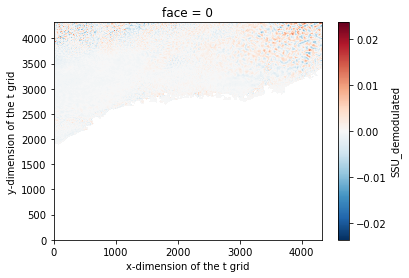

In [72]:
ds.mean('time').SSU_demodulated.real.plot()

In [74]:
ds.j

<xarray.DataArray 'j' (j: 2160)>
array([   0,    2,    4, ..., 4314, 4316, 4318])
Coordinates:
  * j        (j) int64 0 2 4 6 8 10 12 14 ... 4306 4308 4310 4312 4314 4316 4318
    face     int64 0
Attributes:
    axis:           Y
    long_name:      y-dimension of the t grid
    standard_name:  y_grid_index
    swap_dim:       YC

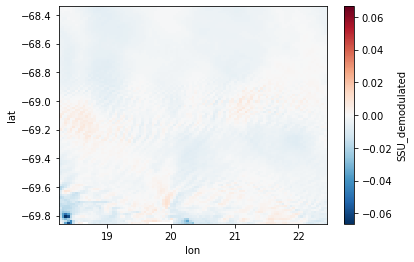

In [46]:
dsi.mean('time').SSU_demodulated.real.plot(x='lon',y='lat')

In [5]:
ds['zonal_velocity_demodulated'] = ds['SSU_demodulated']*ds.CS - ds['SSV_demodulated']*ds.SN
ds['meridional_velocity_demodulated'] =  ds['SSU_demodulated']*ds.SN + ds['SSV_demodulated']*ds.CS

In [52]:
#

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/xarray/core/indexing.py:1375: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]


In [70]:
ds = ds.assign_coords({'lon':ds.lon,'lat':ds.lat})
ds = ds.persist()

In [54]:
ds

<xarray.Dataset>
Dimensions:          (face: 13, i: 2160, j: 2160, time: 1464)
Coordinates:
  * i                (i) int64 0 2 4 6 8 10 12 ... 4308 4310 4312 4314 4316 4318
  * j                (j) int64 0 2 4 6 8 10 12 ... 4308 4310 4312 4314 4316 4318
    CS               (j, i) float32 dask.array<chunksize=(144, 96), meta=np.ndarray>
    Depth            (j, i) float32 dask.array<chunksize=(144, 96), meta=np.ndarray>
    SN               (j, i) float32 dask.array<chunksize=(144, 96), meta=np.ndarray>
    XC               (j, i) float32 dask.array<chunksize=(144, 96), meta=np.ndarray>
    YC               (j, i) float32 dask.array<chunksize=(144, 96), meta=np.ndarray>
    rA               (j, i) float32 dask.array<chunksize=(144, 96), meta=np.ndarray>
  * time             (time) datetime64[ns] 2011-11-15 ... 2012-11-14T18:00:00
  * face             (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
    lon              (face, j, i) float32 dask.array<chunksize=(1, 2160, 2160), meta=np.ndarray>
    lat              (face, j, i) float64 dask.array<chunksize=(1, 2160, 2160), meta=np.ndarray>
Data variables:
    SSU_demodulated  (j, i, time) complex128 dask.array<chunksize=(144, 96, 1464), meta=np.ndarray>
    SSU_hat          (j, i, time) complex128 dask.array<chunksize=(144, 96, 1464), meta=np.ndarray>
    SSV_demodulated  (j, i, time) complex128 dask.array<chunksize=(144, 96, 1464), meta=np.ndarray>
    SSV_hat          (j, i, time) complex128 dask.array<chunksize=(144, 96, 1464), meta=np.ndarray>
Attributes:
    Tw:         30
    bandwidth:  0.4
    dt:         6h
    face:       0
    omega:      1.9661368071336223

In [24]:
ds.isel(time=slice(0,10)).SSU_demodulated.real.mean('time').plot(vmax=0.2,x='lon',y='lat')

KeyboardInterrupt: 

In [60]:
cluster.close()